# Part a) - Ordinary least squares on Franke's function

In [3]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

sns.set_theme(style='whitegrid')
np.random.seed(42)

In [4]:
def FrankeFunction(x,y): # from project description
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [85]:
def polynomial_matrix_2D(x, y, p, no_intercept=True):
	"""Variables x and y, degree p"""
	n = len(x) # number of data points
	if p == 0: return np.ones((n,1))

	l = int((p+1)*(p+2)/2) # number of elements in beta
	X = np.zeros((n,l-no_intercept))

	idx = int(not no_intercept)
	for degree in range(1,p+1):
		for ydegree in range(degree+1):
			X[:, idx] = (x**(degree - ydegree)) * (y**ydegree)
			idx += 1
		
	return X

In [91]:
# Generating dataset
n = 1000 # number of datapoints
#x,y = np.ones(n)*2, np.ones(n)*3 # for testing
x, y = np.random.rand(n), np.random.rand(n) # input to Franke's function
k = 0 # noise coefficient
z = FrankeFunction(x,y) + k*np.random.randn(n) # target variable with standard normal noise


# Creating design matrix
p = 5 # highest polynomial degree
l = int((p+1)*(p+2)/2) # longest beta
N = np.arange(p+1) # for looping and plotting later

MSE_OLS_train, MSE_OLS_test = np.zeros(p), np.zeros(p)
R2_OLS_train, R2_OLS_test = np.zeros(p), np.zeros(p)
beta_values = np.zeros((p+1,l))

for i in N:
    # Constructing the design matrix
    X = polynomial_matrix_2D(x, y, i, no_intercept=True) # degree i, no intercept

    # Splitting the data (note that y_... has nothing to do with y)
    X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, random_state=3)

    # Scaling the data (only centering)
    y_train_mean = np.mean(y_train)
    y_train_centered = y_train - y_train_mean

    if i == 0: beta_values[0,0] = y_train_mean; continue # degree 0 case

    X_train_mean = np.mean(X_train, axis=0) # 1D array of each column mean
    X_train_centered = X_train - X_train_mean
    X_test_centered = X_test - X_train_mean # centering with training data

    # Solving OLS
    beta_OLS = np.linalg.inv(X_train_centered.T @ X_train_centered) @ X_train_centered.T @ y_train_centered
    intercept = y_train_mean # - np.dot(X_train_mean, beta_OLS.ravel()) # recovering intercept, !!! something wrong here, see next comment !!! could use y_train_mean as intercept

    y_tilde_OLS = X_train_centered @ beta_OLS + intercept # predictor on training data, !!! y_train_mean is much better than intercept, seemingly !!!
    y_predict_OLS = X_test_centered @ beta_OLS + intercept # predictor on test data, !!! we are SUPPOSED to use intercept here !!!

    MSE_OLS_train[i-1] = mean_squared_error(y_tilde_OLS, y_train)
    MSE_OLS_test[i-1] = mean_squared_error(y_predict_OLS, y_test)
    R2_OLS_train[i-1] = r2_score(y_tilde_OLS, y_train)
    R2_OLS_test[i-1] = r2_score(y_predict_OLS, y_test)

    beta_values[i,0] = intercept
    beta_values[i,1:len(beta_OLS)+1] = beta_OLS.T

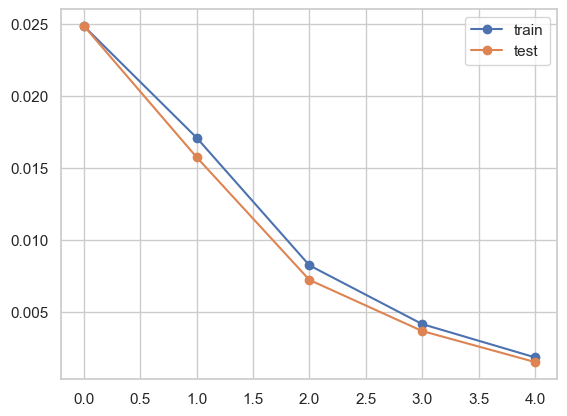

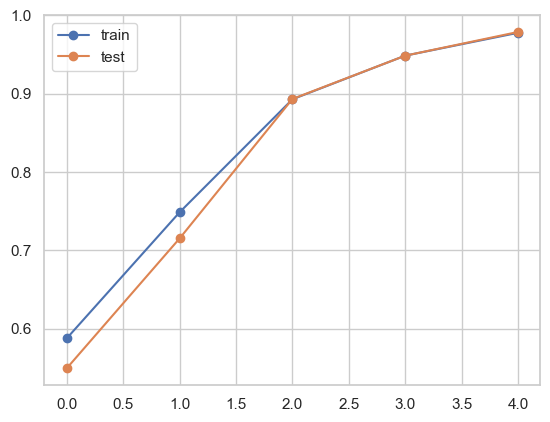

In [92]:
N = np.arange(p)

# Plotting OLS MSE and R2 against complexity
plt.plot(N, MSE_OLS_train, 'o-', label='train')
plt.plot(N, MSE_OLS_test, 'o-', label='test')
plt.legend(); plt.show()

plt.plot(N,R2_OLS_train, 'o-', label='train')
plt.plot(N,R2_OLS_test, 'o-', label='test')
plt.legend(); plt.show()